# This code is intended to be used for offline analysis of the seismic and magnetic data retreived from the WebDAQ during site surveying.

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
from ipywidgets import FloatSlider
from ipywidgets import Layout 
from scipy import signal
from matplotlib import gridspec


################################################################################################################################
################################## This will be for the data you collect with the magnetometer #################################
################################################################################################################################

mag = pd.read_csv(r"C:\Users\cacam\Downloads\Mag_proper.csv", delimiter=',') 

samples = mag['Sample']
times = mag['Time (s)']
noise = mag['Noise (V)']
k = mag['Voltage Z (V)']
j = mag['Voltage Y (V)']
i = mag['Voltage X (V)']

############################################ This is the sample rate we used in testing ########################################
mag_rate = 25600 
############################################# If you used something else, put it here ##########################################


################################################################################################################################
################################################## This the magnetometer data ##################################################
################################################################################################################################

seis = pd.read_csv(r"C:\Users\cacam\Downloads\seismo_proper.csv", delimiter=',') #sesimo_test

sam = seis['Sample']
tim = seis['Time (s)']
noi = seis['Noise (V)']
z = seis['Channel Z (V)']
n = seis['Channel N (V)']
e = seis['Channel E (V)']

#################################### Again, if you used a different sample rate, put it here ###################################
seis_rate = 1651.612903 

### This next cell will be a time series of the data you collected. Though, be warned. This graphical slider was not intended to be used on such a sample dense plot, so there will be a delay. Also, slide across in slow increments or it will crash.

In [3]:
Min = min(k.min(), j.min(), i.min())
Max = max(k.max(), j.max(), i.max())

def plot_with_slider(xlim):
    
    plt.figure(figsize=(19, 8))   ## dpi breaks slider
    
    plt.plot(times, i, linewidth = 1.5, label = 'X', color = 'red')
    plt.plot(times, k, linewidth = 1.5, label = 'Z', color = 'black')
    plt.plot(times, j, linewidth = 1.5, label = 'Y', color = 'blue')
    
    plt.xlim(xlim, xlim + 15)   
    plt.ylim(Min , Max + 0.25) 
    '''
    plt.legend(loc = 'upper right', fontsize = 15)
    plt.title("Electromagentic Data", fontweight = 'bold', fontsize = 25)
    plt.xlabel("Time (s)", fontweight = "bold", fontsize = 20)
    plt.ylabel("Amplitude (V)", fontweight = "bold", fontsize = 20)
    '''
    plt.grid(True)
    plt.show()


interact(plot_with_slider, xlim = FloatSlider(min = 0, max = (times[len(times)-1]), step = 3, value = 0, 
                                              layout=Layout(width='980px')))


interactive(children=(FloatSlider(value=0.0, description='xlim', layout=Layout(width='980px'), max=302.919961,…

<function __main__.plot_with_slider(xlim)>

## This will determine how large a window you wish to look at for your power spectral density plot/calculations

In [ ]:
############################### Enter how long of a time segment you'd like to calculate with ##################################
start = 0  ## In terms of seconds
end = 100

a = 0
b = 0

################################################################################################################################
############################# This loop is for selecting only the start-end data from the file #################################

for a in range(0, len(times)):
    if times[a] == start:
        alpha = samples[b]
        break
        
for b in range(0, len(times)):
    if times[b] == end:
        beta = samples[b]
        break


t = times[alpha:beta]
#ns = noise[alpha:beta]
k1 = k[alpha:beta]
j1 = j[alpha:beta]
i1 = i[alpha:beta]

## This cell is where the PSD is calculated and plotted

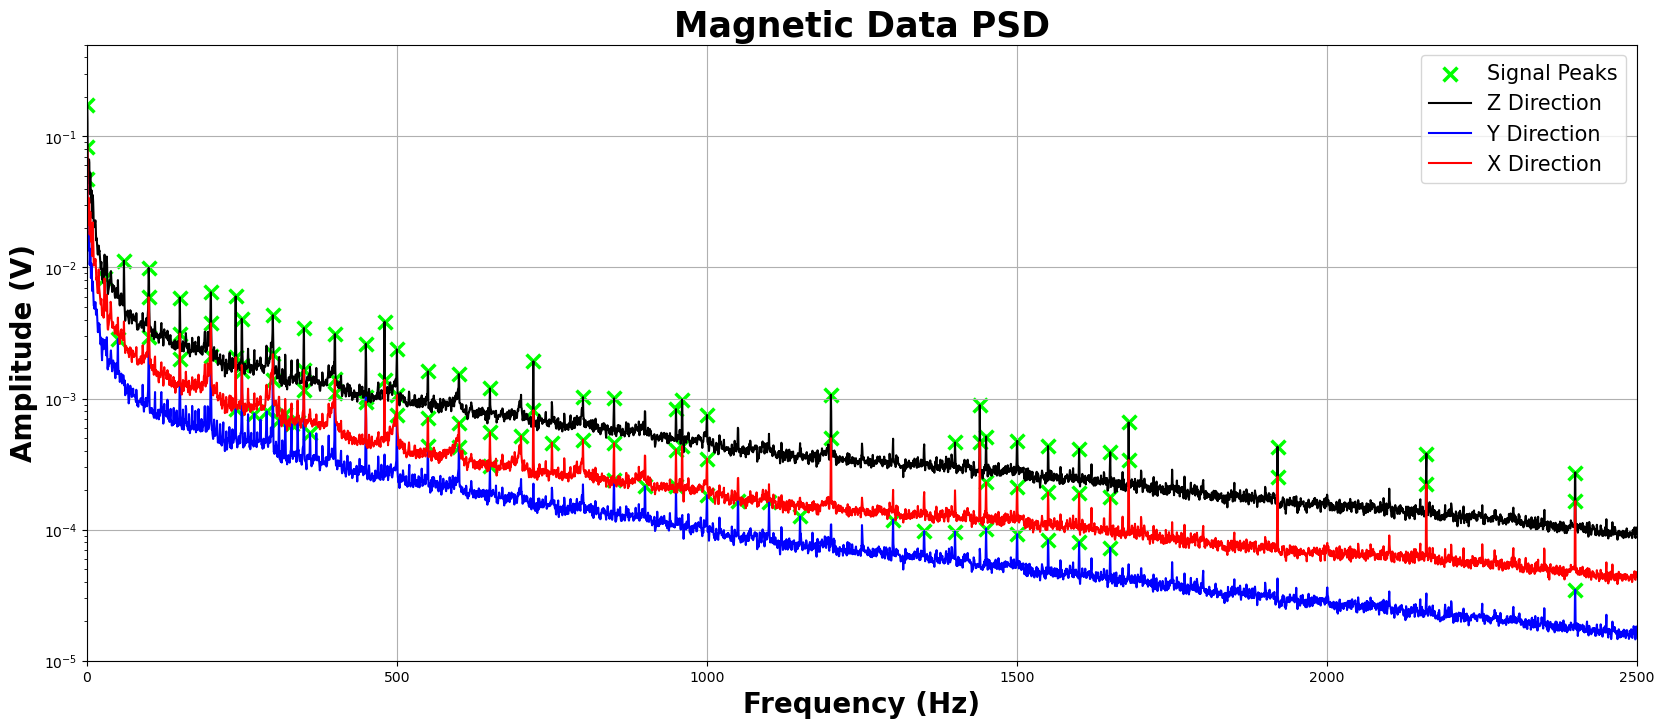

In [17]:
################################################################################################################################
######################################## The PSD is calculated via welch from scipy ############################################
################################################################################################################################


f_k, Pxx_den_k = signal.welch(k1, mag_rate, window='hamming', nperseg= (mag_rate * 2)) # If need be, you can change the window #
f_j, Pxx_den_j = signal.welch(j1, mag_rate, window='hamming', nperseg= (mag_rate * 2)) ###############   HOWEVER   #############
f_i, Pxx_den_i = signal.welch(i1, mag_rate, window='hamming', nperseg=(mag_rate * 2))  ### do not change the other variables ###
                                                                                       

l_k = np.log(Pxx_den_k)
l_j = np.log(Pxx_den_j) ############# The log of each PSD must be found in order to find the peaks/frequences ##################
l_i = np.log(Pxx_den_i)


peaks_k, _ = signal.find_peaks(l_k, prominence = 1.2) ############# This is where the frequencies are found ####################
peaks_j, _ = signal.find_peaks(l_j, prominence = 1.2) ############## If some are missed or there are extra #####################
peaks_i, _ = signal.find_peaks(l_i, prominence = 1.2) ######### you will need to change the prominence variable ################


################################################################################################################################

plt.figure(figsize = (20, 8))

plt.scatter(f_k[peaks_k], Pxx_den_k[peaks_k] ** 0.5, s = 100, color = 'lime', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')
plt.scatter(f_j[peaks_j], Pxx_den_j[peaks_j] ** 0.5, s = 100, color = 'lime', marker = 'x', 
            linewidths = 2.5)
plt.scatter(f_i[peaks_i], Pxx_den_i[peaks_i] ** 0.5, s = 100, color = 'lime', marker = 'x', 
            linewidths = 2.5)

plt.semilogy(f_k, Pxx_den_k ** 0.5, color = 'black', linewidth = 1.5, label = 'Z Direction')
plt.semilogy(f_j, Pxx_den_j ** 0.5, color = 'blue', linewidth = 1.5, label = 'Y Direction')
plt.semilogy(f_i, Pxx_den_i ** 0.5, color = 'red', linewidth = 1.5, label = 'X Direction')

plt.legend(loc = "upper right", fontsize = 15)
plt.title("Magnetic Data PSD", fontweight = 'bold', fontsize = 25)
plt.xlabel("Frequency (Hz)", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude (V)", fontweight = "bold", fontsize = 20)

plt.ylim(10e-6, 0.5)
plt.xlim(0, 2500)
plt.grid(True)


## The following cell will plot each of direction signal in their own respective plots
### If you don't want/need to look at them individually, you don't have to run it

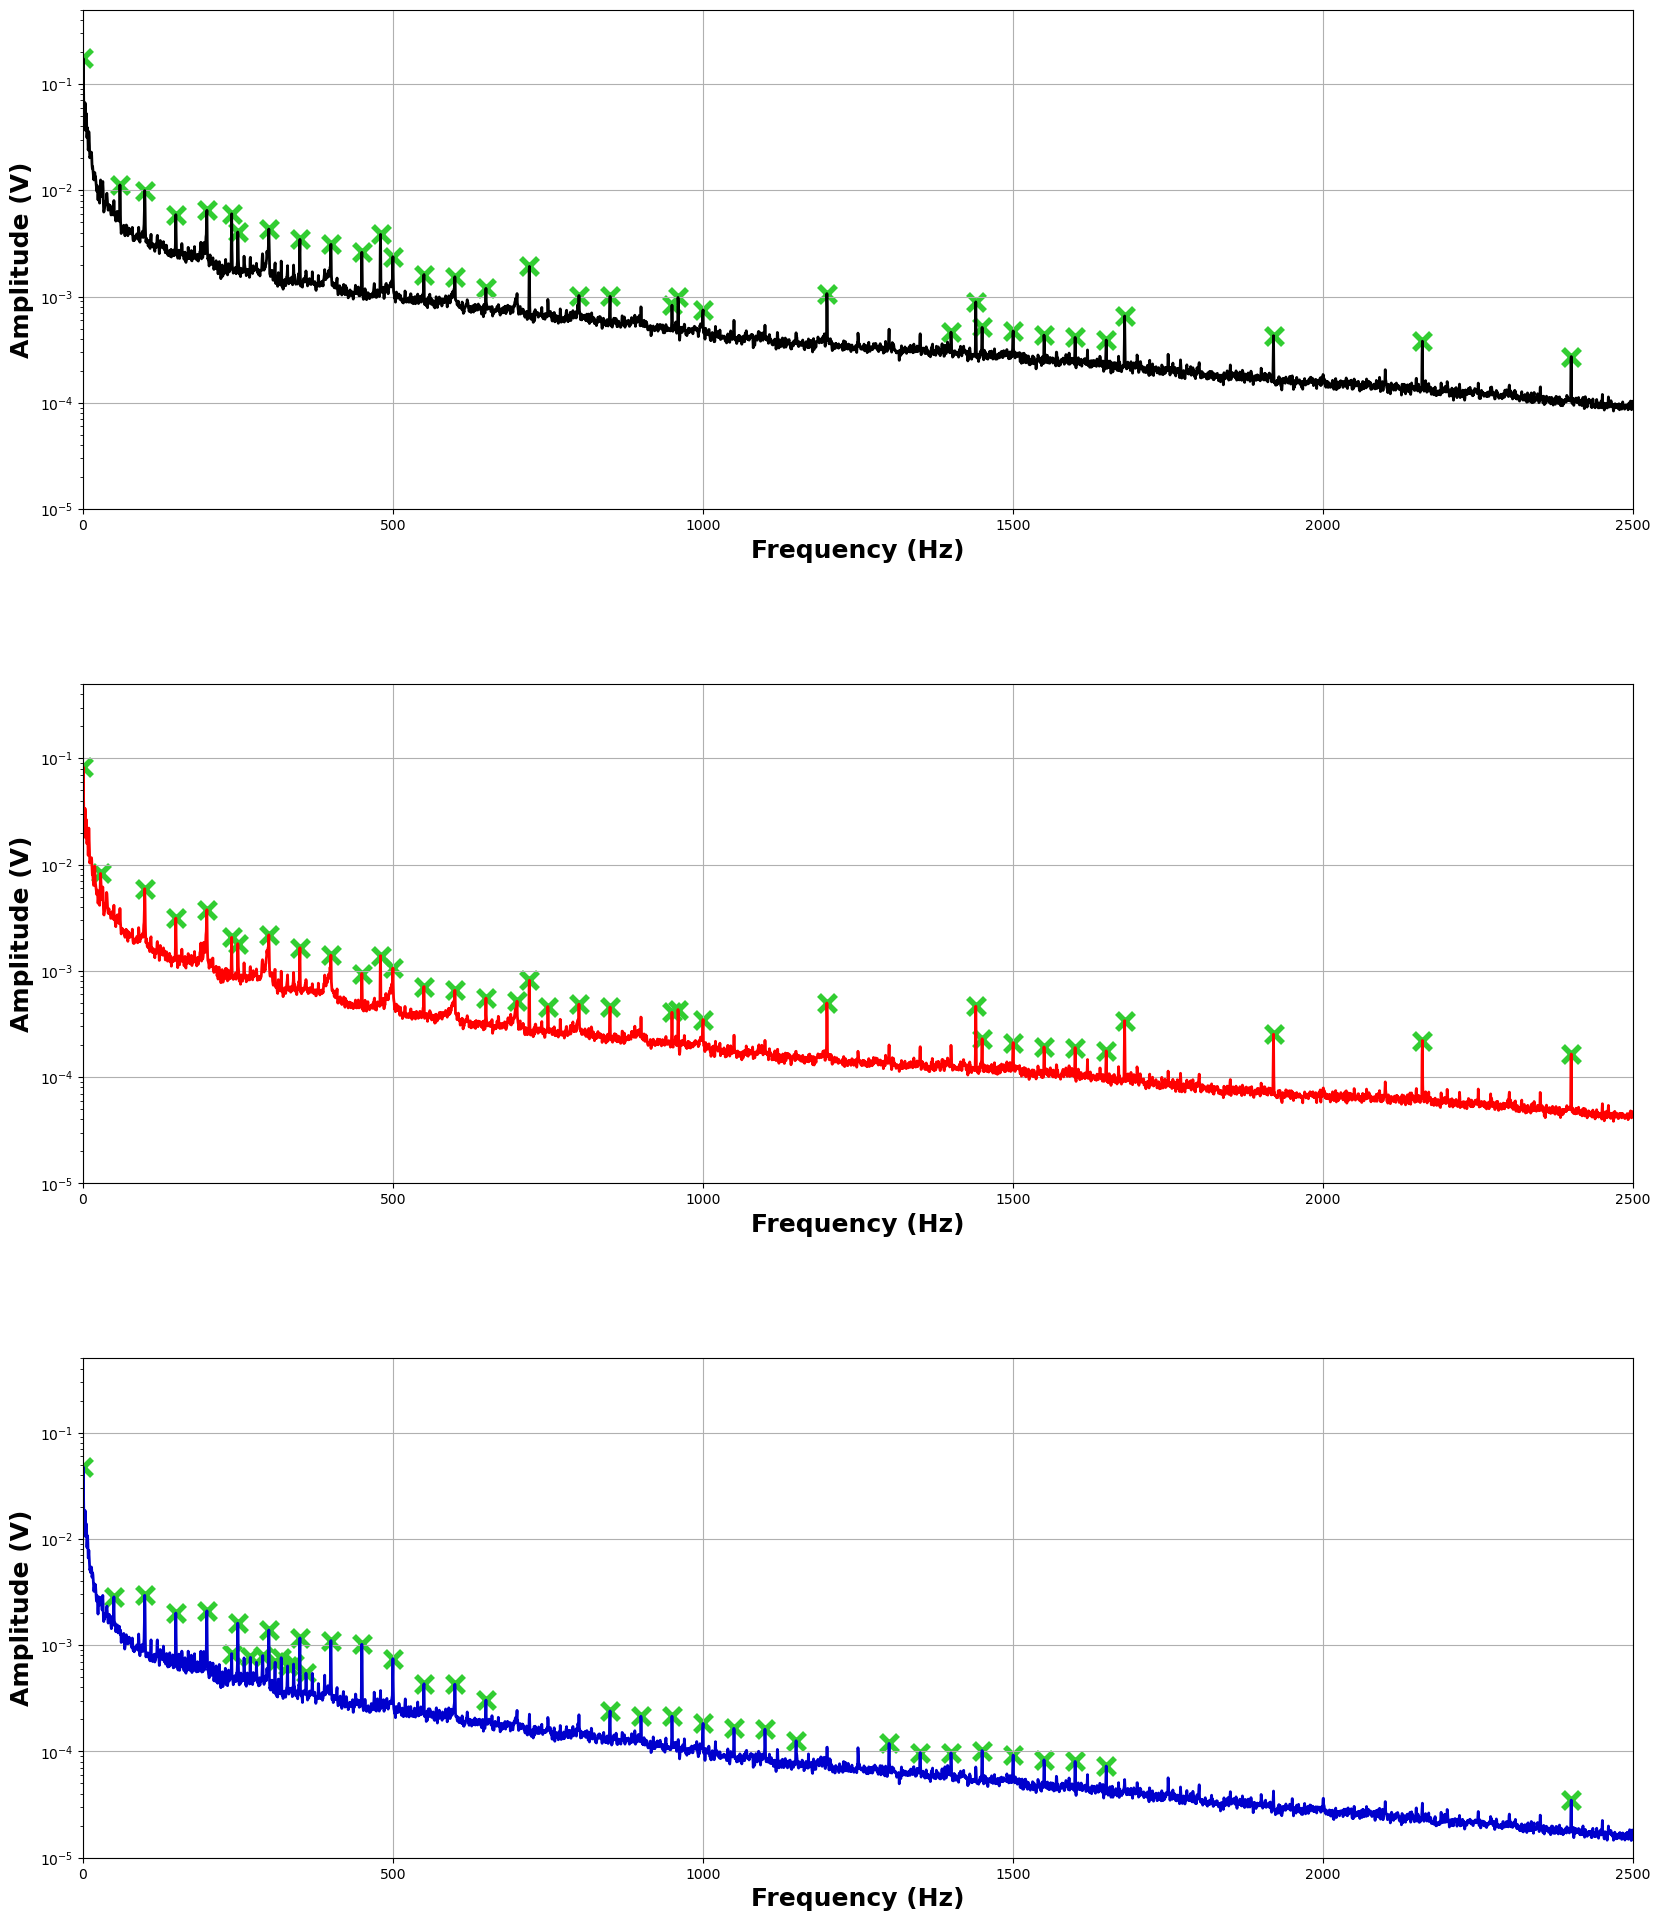

In [14]:
fig = plt.figure(figsize = (20,24)) #, dpi = 2500)

gs = gridspec.GridSpec(3,1, height_ratios = [1,1,1], hspace = 0.35)

axis1 = fig.add_subplot(gs[0,0])

axis1.scatter(f_k[peaks_k], Pxx_den_k[peaks_k] ** 0.5, s = 150, color = 'limegreen', marker = 'x', 
              linewidths = 4, label = 'Signal Peaks')
axis1.semilogy(f_k, Pxx_den_k ** 0.5, color = 'black', linewidth = 2, label = 'Channel Z')

axis1.set_xlabel("Frequency (Hz)", fontweight = "bold", fontsize = 18)
axis1.set_ylabel("Amplitude (V)", fontweight = "bold", fontsize = 18)

axis1.set_ylim([10e-6, 0.5])
axis1.set_xlim(0, 2500)
axis1.grid(True)

################################################################################################################################

axis2 = fig.add_subplot(gs[1,0])

axis2.scatter(f_i[peaks_i], Pxx_den_i[peaks_i] ** 0.5, s = 150, color = 'limegreen', marker = 'x', 
              linewidths = 4)
axis2.semilogy(f_i, Pxx_den_i ** 0.5, color = 'red', linewidth = 2, label = 'Channel N')

axis2.set_xlabel("Frequency (Hz)", fontweight = "bold", fontsize = 18)
axis2.set_ylabel("Amplitude (V)", fontweight = "bold", fontsize = 18)

axis2.set_ylim([10e-6, 0.5])
axis2.set_xlim(0, 2500)
axis2.grid(True)

################################################################################################################################

axis3 = fig.add_subplot(gs[2,0])

axis3.scatter(f_j[peaks_j], Pxx_den_j[peaks_j] ** 0.5, s = 150, color = 'limegreen', marker = 'x', 
              linewidths = 4)
axis3.semilogy(f_j, Pxx_den_j ** 0.5, color = 'mediumblue', linewidth = 2, label = 'Channel E')

axis3.set_xlabel("Frequency (Hz)", fontweight = "bold", fontsize = 18)
axis3.set_ylabel("Amplitude (V)", fontweight = "bold", fontsize = 18)

axis3.set_ylim([10e-6, 0.5])
axis3.set_xlim(0, 2500)
axis3.grid(True)

## This cell will print out all the frequencies found and their respective amplitudes

In [61]:
c = 0
g = 0
h = 0
with open (r"C:\Users\cacam\Documents\Mag_frequencies.csv",'w') as f:
        f.write('Frequency (X), Amplitude (X), Frequency (Y), Amplitude (Y), Frequency (Z), Amplitude (Z) \n')
        for c in range(0, len(f_i[peaks_i])):
            if (len(f_i[peaks_i]) != len(f_j[peaks_j]) != len(f_k[peaks_k])):
                
                badwolf = max(len(f_i[peaks_i]), len(f_j[peaks_j]), len(f_k[peaks_k]))
                
                lst = []
                lt = []
                
                if len(f_i[peaks_i]) == badwolf:
                    for g in range(0, badwolf - len(f_j[peaks_j])):
                        lst.append('NaN')
                    for h in range(0, badwolf - len(f_k[peaks_k])):
                        lt.append('NaN')
                        
                    dir1 = np.append(f_j[peaks_j], lst)
                    dir_1 = np.append(Pxx_den_j[peaks_j], lst)
                    dir2 = np.append(f_k[peaks_k], lt)
                    dir_2 = np.append(Pxx_den_k[peaks_k], lst)
                    
                    f.write(str(f_i[peaks_i][c]) + ', ' + str(Pxx_den_i[peaks_i][c]) + ', ' +    
                            str(dir1[c]) + ', ' + str(dir_1[c]) + ', ' +
                            str(dir2[c]) + ', ' + str(dir_2[c]) + '\n')
                    
                    
                elif len(f_j[peaks_j]) == badwolf:
                    for g in range(0, badwolf - len(f_i[peaks_i])):
                        lst.append('NaN')
                    for g in range(0, badwolf - len(f_k[peaks_k])):
                        lt.append('NaN')
                    
                    dir1 = np.append(f_i[peaks_i], lst)
                    dir_1 = np.append(Pxx_den_i[peaks_i], lst)
                    dir2 = np.append(f_k[peaks_k], lt)
                    dir_2 = np.append(Pxx_den_k[peaks_k], lst)
                    
                    
                    f.write(str(dir1[c]) + ', ' + str(dir_1) + ', ' +    
                            str(f_j[peaks_j][c]) + ', ' + str(Pxx_den_j[peaks_j][c]) + ', ' +
                            str(dir2[c]) + ', ' + str(dir_2[c]) + '\n')

                    
                elif len(f_k[peaks_k]) == badwolf:
                    for g in range(0, badwolf - len(f_j[peaks_j])):
                        lst.append('NaN')
                    for g in range(0, badwolf - len(f_k[peaks_i])):
                        lt.append('NaN')
                    
                    dir1 = np.append(f_i[peaks_i], lst)
                    dir_1 = np.append(Pxx_den_i[peaks_i], lst)
                    dir2 = np.append(f_j[peaks_j], lt)
                    dir_2 = np.append(Pxx_den_j[peaks_j], lst)
                    
                    
                    f.write(str(dir1[c]) + ', ' + str(dir_1) + ', ' +    
                            str(dir2[c]) + ', ' + str(dir_2[c]) + ', ' +
                            str(f_k[peaks_k][c]) + ', ' + str(f_k[peaks_k][c]) + '\n')
                   
                
            else:
                f.write(str(f_i[peaks_i][c]) + ', ' + str(Pxx_den_i[peaks_i][c]) + ', ' +    
                        str(f_j[peaks_j][c]) + ', ' + str(Pxx_den_j[peaks_j][c]) + ', ' +
                        str(f_k[peaks_k][c]) + ', ' + str(Pxx_den_k[peaks_k][c]) + '\n')

## The following section is for the sesimometer data
### However, everything is the same as for the magnetometer

In [10]:
Min = min(z.min(), n.min(), e.min())
Max = max(z.max(), n.max(), e.max())


def plot_with_slider(xlim):

    plt.figure(figsize=(19, 8))   ## dpi breaks slider
    
    plt.plot(tim, z, linewidth = 1.75, color = 'black', label = 'Z')
    plt.plot(tim, n, linewidth = 1.75, color = 'red', label = 'N')
    plt.plot(tim, e, linewidth = 1.75, color = 'mediumblue', label = 'E')
    
    plt.legend(loc = "upper right", fontsize = 15)
    plt.title("Seismic Data", fontweight = 'bold', fontsize = 25)
    plt.xlabel("Time (s)", fontweight = "bold", fontsize = 20)
    plt.ylabel("Amplitude (V)", fontweight = "bold", fontsize = 20)
    
    plt.xlim(xlim, xlim + 10)   
    plt.ylim(Min - 2, Max + 1) 
    #plt.axhline()
    plt.grid(True)
    plt.show()


interact(plot_with_slider, xlim = FloatSlider(min = 0, max = (tim[len(tim)-1]), step = 3, value = 0, 
                                              layout=Layout(width='980px')))


interactive(children=(FloatSlider(value=0.0, description='xlim', layout=Layout(width='980px'), max=312.440645,…

<function __main__.plot_with_slider(xlim)>

In [19]:
start = 0  ##in terms of seconds 
end = 100   # times[len(times)-1]

d = 0
f = 0

for d in range(0, len(tim)):
    if round(tim[d]) == start:
        gamma = sam[d]
        break
        
for f in range(0, len(tim)):
    if round(tim[f]) == end:
        delta = sam[f]
        break

t1 = tim[gamma:delta]
#no = noi[gamma:delta]
z1 = z[gamma:delta]
n1 = n[gamma:delta]
e1 = e[gamma:delta]


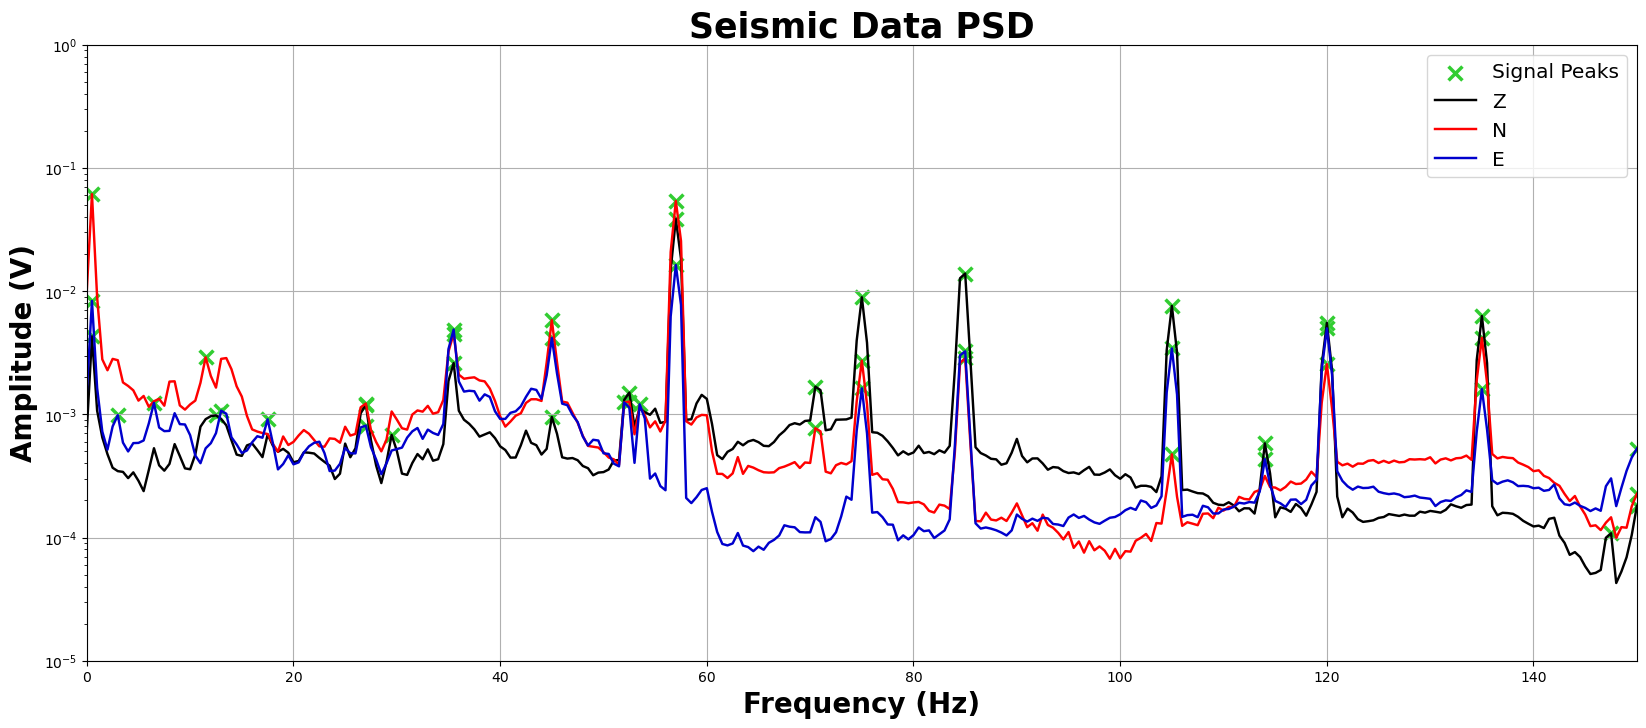

In [20]:
f_z, Pxx_den_z = signal.welch(z1, seis_rate, window = 'hamming', nperseg = (seis_rate * 2)) 
f_n, Pxx_den_n = signal.welch(n1, seis_rate, window = 'hamming', nperseg = (seis_rate * 2))
f_e, Pxx_den_e = signal.welch(e1, seis_rate, window = 'hamming', nperseg = (seis_rate * 2))

log_z = np.log(Pxx_den_z)
log_n = np.log(Pxx_den_n)
log_e = np.log(Pxx_den_e)

peak_z, _ = signal.find_peaks(log_z, prominence = 1.2)
peak_n, _ = signal.find_peaks(log_n, prominence = 1.2)
peak_e, _ = signal.find_peaks(log_e, prominence = 1.2)

plt.figure(figsize = (20, 8))#, dpi = 2500)

plt.scatter(f_z[peak_z], Pxx_den_z[peak_z] ** 0.5, s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')
plt.scatter(f_n[peak_n], Pxx_den_n[peak_n] ** 0.5, s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)
plt.scatter(f_e[peak_e], Pxx_den_e[peak_e] ** 0.5, s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)

plt.semilogy(f_z, Pxx_den_z ** 0.5, color = 'black', linewidth = 1.75, label = 'Z')
plt.semilogy(f_n, Pxx_den_n ** 0.5, color = 'red', linewidth = 1.75, label = 'N')
plt.semilogy(f_e, Pxx_den_e ** 0.5, color = 'mediumblue', linewidth = 1.75, label = 'E')


#'''
plt.legend(loc = "upper right", fontsize = 14.5)
plt.title("Seismic Data PSD", fontweight = 'bold', fontsize = 25)
plt.xlabel("Frequency (Hz)", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude (V)", fontweight = "bold", fontsize = 20)
#'''
plt.ylim([10e-6, 1])
plt.xlim(0, 150)
plt.grid(True)